# Image Captioning with Visual Attention

The goal of this project is to create an image captioning model that can accurately describe the highlights of the image in a way that humans would. For example, the generated caption for the below image might be, "Some people are playing basketball."

<div><img src="readme_images/baseball.jpeg" width="500"></div>

I utilized an attention-based encoder-decoder model to convert an image into the corresponding caption. The model architecture is referenced from [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

## Learning Outcome

1. Created an image captioning model using Keras, which involved encoder, decoder, and predictor.
1. Learned the key concepts of visual attention and combined them with a text generation model.
1. Loaded the image and caption data from the COCO dataset and preprocessed them using techniques like normalization and tokenization.
1. Utilized Keras Functional API to reuse the layers and the weights of various models.

## Preparation

Download dependencies.



In [ ]:
import time
from textwrap import wrap

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.layers import (
    GRU,
    Add,
    AdditiveAttention,
    Attention,
    Concatenate,
    Dense,
    Embedding,
    LayerNormalization,
    Reshape,
    StringLookup,
    TextVectorization,
)

print(tf.version.VERSION)

2.15.0


## Prepare Data

### *Data source*

I used [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) dataset. This dataset contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes care of some data quality issues with the original dataset.

### *Data Preprocessing*

The data come in following format:

```
FeaturesDict({
    'captions': Sequence({
        'id': int64,
        'text': string,
    }),
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'image/id': int64,
    'objects': Sequence({
        'area': int64,
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'id': int64,
        'is_crowd': bool,
        'label': ClassLabel(shape=(), dtype=int64, num_classes=80),
    }),
})
```

Here I preprocess the dataset:
- Fetch the first caption (I don't need too many simliar data)
- Resize image to (299, 299) shape, which is the requirement for the feature extractor [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2)
- Normalize the iamge pixel values from [0, 255] to [0, 1]
- Return image(`image_tensor`) and captions(`captions`) dictionary.


**Note**: This dataset is too large to store in an local environment. Therefore, It is stored in a public GCS bucket located in us-central1.
So if you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.

In [ ]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"
BUFFER_SIZE = 1000

IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3

def get_image_label(example):
    caption = example["captions"]["text"][0]  # only the first caption per image
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "caption": caption}


trainds = tfds.load("coco_captions", split="train", data_dir=GCS_DIR)

trainds = trainds.map(
    get_image_label, num_parallel_calls=tf.data.AUTOTUNE
).shuffle(BUFFER_SIZE)
trainds = trainds.prefetch(buffer_size=tf.data.AUTOTUNE)

### Visualize
Here are some samples from my new dataset.

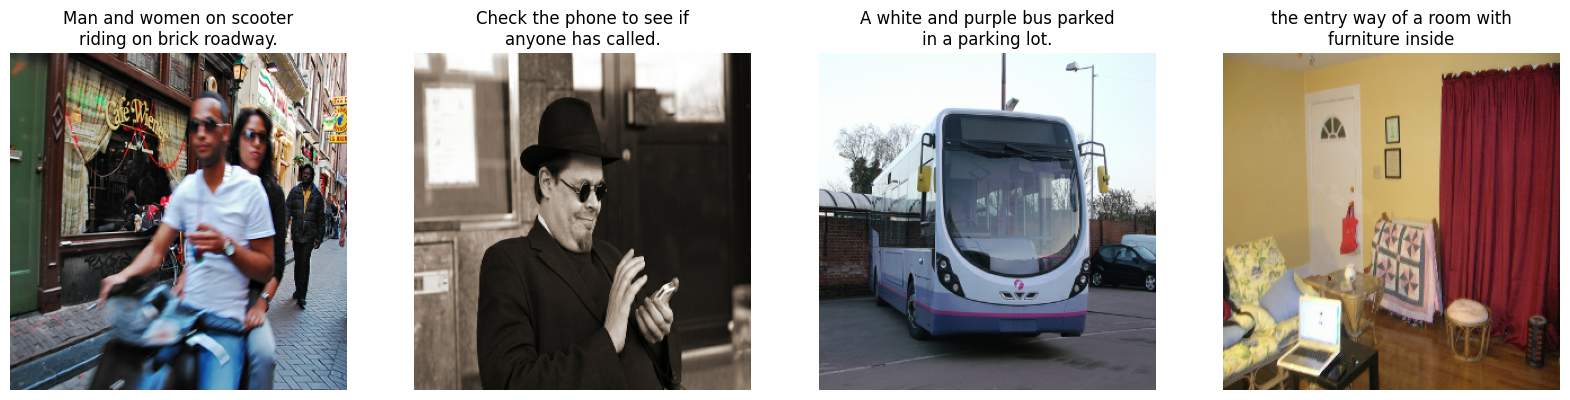

In [ ]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    caption = "\n".join(wrap(data["caption"].numpy().decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")



### Image Feature Extractor

I'll use the pretrained [InceptionResNetV2](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/InceptionResNetV2) from `tf.keras.applications` as a feature extractor.

`tf.keras.applications` is a pretrained model repository like [TensorFlow Hub](https://tfhub.dev), but while Tensorflow Hub hosts models for different modalities including image, text, audio, and so on, `tf.keras.application` only hosts popular and stable models for images.

However, `tf.keras.applications` is more flexible as it contains model metadata and it allow us to access and control the model behavior, while most of the TensorFlow Hub based models that only contains compiled SavedModels.

So, for example, we can get output not only from the final layer of the model (e.g. flattend 1D Tensor output of CNN models), but also from intermediate layers (e.g. intermediate 3D Tensor) by accessing layer metadata.

In [ ]:
# Change these to control the accuracy/speed
ATTENTION_DIM = 512  # size of dense layer in Attention
WORD_EMBEDDING_DIM = 128 # more embeddings lead to more complex behavior

# InceptionResNetV2 takes (299, 299, 3) image as inputs
# and return features in (8, 8, 1536) shape
FEATURE_EXTRACTOR = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False, weights="imagenet"
)

219055592/219055592 [==============================] - 10s 0us/step


## Text Preprocessing

Add special tokens to represent the starts (`<start>`) and the ends (`<end>`) of sentences to give the encoder-decoder model a sense of sentence structure.


In [ ]:
def add_start_end_token(data):
    start = tf.convert_to_tensor("<start>")
    end = tf.convert_to_tensor("<end>")
    data["caption"] = tf.strings.join(
        [start, data["caption"], end], separator=" "
    )
    return data


trainds = trainds.map(add_start_end_token)

## Text Tokenization

Transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization):

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top `VOCAB_SIZE` words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to the length `MAX_CAPTION_LEN`. For this dataset, `64` should be long enough to capture all captions.

**Note**: Don't forget to override the `standardize` paramter with a custom function to preserve < and > characters for the custome tokens `<start>` and `<end>`.

In [ ]:
MAX_CAPTION_LEN = 64
VOCAB_SIZE = 20000  # use fewer words to speed up convergence

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(
        inputs, r"[!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~]?", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)

tokenizer.adapt(trainds.map(lambda x: x["caption"])) # trainds contains both images and caption - pass only the captions.

Tokenized text sample:

In [ ]:
sample_captions = []
for d in trainds.take(5):
    sample_captions.append(d["caption"].numpy())

In [ ]:
sample_captions

[b'<start> Animal seen in the water with bubbles surrounding it.  <end>',
 b'<start> A man sitting at a table with a plate of cake. <end>',
 b'<start> A man riding a skateboard up the side of a ramp. <end>',
 b'<start> a man with a tie wearing some headphones  <end>',
 b'<start> A refrigerator door wide open with lots of food on it. <end>']

In [ ]:
print(tokenizer(sample_captions))

tf.Tensor(
[[   3  367  471    8    7   55    9 3950 1199   35    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2   12   14   21    2   25    9    2   40    5  107    4    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   3    2   12   34    2   81   41    7   63    5    2  326    4    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

Also, we can create Word <-> Index converters using `StringLookup` layer.

In [ ]:
# Lookup table: Word -> Index
word_to_index = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

and I can convert ids to original text.

In [ ]:
for wordid in tokenizer([sample_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> animal seen in the water with bubbles surrounding it <end>                                                      

### Create a tf.data dataset for training

Now Let's apply the tokenization to all the examples and create tf.data Dataset for training.

While I'm at it, I'll create labels by shifting texts from feature captions.

For example, if the caption is `"<start> I love cats <end>"`, its label should be `"I love cats <end> <padding>"`. With that, the model can try to predict the next word based on what it has so far - learning to predict `I` from `<start>`, for instance.

The dataset contains tuples, where the first elements are features (`image_tensor` and `caption`) and the second elements are labels (`target`).

In [ ]:
BATCH_SIZE = 32

# feed my custom dataset
def create_ds_fn(data):
    img_tensor = data["image_tensor"]
    caption = tokenizer(data["caption"])

    target = tf.roll(caption, -1, 0) # shift the caption to left
    zeros = tf.zeros([1], dtype=tf.int64) # add paddings
    target = tf.concat((target[:-1], zeros), axis=-1) # remove the right-most token (the one that just got shifted) and concat with the padding
    return (img_tensor, caption), target


batched_ds = (
    trainds.map(create_ds_fn)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Let's take a look at some examples.

In [ ]:
for (img, caption), label in batched_ds.take(2):
    print(f"Image shape: {img.shape}")
    print(f"Caption shape: {caption.shape}")
    print(f"Label shape: {label.shape}")
    print(caption[0])
    print(label[0])

Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2   61    9  210    5 1331   10 2640  470   13   35    4    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
tf.Tensor(
[   2   61    9  210    5 1331   10 2640  470   13   35    4    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(64,), dtype=int64)
Image shape: (32, 299, 299, 3)
Caption shape: (32, 64)
Label shape: (32, 64)
tf.Tensor(
[   3    2  138 2657  208    9    2   45  495    8   35    4    0    0
    0    0    0    0    0    0    0 

## Model Architecture

The image captioning model consists of an image encoder, followed by a caption decoder.


### Image Encoder

The image encoder model extracts features through a pre-trained model and passes them to a fully connected layer. Set `trainable` parameter to `False` to prevent the contamination of the pre-trained `InceptionResNetV2` feature extractor from learning further.  

Define layers in Keras Functional API so that I can easily combine it with the decoder layer later.

Architecture:
1. Extract the features from convolutional layers, which gives a vector of `(Batch Size, 8, 8, 1536)`.
2. Reshape the vector to `(Batch Size, 64, 1536)`.
3. Squash it to a length of `ATTENTION_DIM` with a Dense Layer and return `(Batch Size, 64, ATTENTION_DIM)`

Later, this image encoding output will be fed to the the Attention layer to predict the next word.


In [ ]:
FEATURE_EXTRACTOR.trainable = False
FEATURES_SHAPE = (8, 8, 1536) # features shape of InceptionResNetV2

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
image_features = FEATURE_EXTRACTOR(image_input)

x = Reshape((FEATURES_SHAPE[0] * FEATURES_SHAPE[1], FEATURES_SHAPE[2]))(
    image_features
)
encoder_output = Dense(ATTENTION_DIM, activation="relu")(x)

In [ ]:
encoder = tf.keras.Model(inputs=image_input, outputs=encoder_output)
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_resnet_v2 (Funct  (None, None, None, 1536   54336736  
 ional)                      )                                   
                                                                 
 reshape (Reshape)           (None, 64, 1536)          0         
                                                                 
 dense (Dense)               (None, 64, 512)           786944    
                                                                 
Total params: 55123680 (210.28 MB)
Trainable params: 786944 (3.00 MB)
Non-trainable params: 54336736 (207.28 MB)
_________________________________________________________________


### Caption Decoder
The caption decoder incorporates an attention mechanism that focuses on different parts of the input image.


#### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example.

Let's look at how this works:

<img src="readme_images/attention1.png" alt="attention equation 1" width="800">

<img src="readme_images/attention2.png" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="readme_images/attention3.png" alt="attention equation 3" width="800">

This notebook implement Luong-style attention using pre-defined `layers.Attention`.

#### Decoder Steps

The decoder's job is to generate predictions for the next output token.

1. The decoder receives current word tokens as a batch.
1. It embeds the word tokens to `ATTENTION_DIM` dimension.
1. GRU layer keeps track of the word embeddings, and returns GRU outputs and states.
1. Luong-style attention attends over the encoder's output feature by using GRU outputs as a query.
1. The attention outputs and GRU outputs are added (skip connection), and normalized in a layer normalization layer.
1. It generates logit predictions for the next token based on the GRU output.

Define layers in Keras Functional API so that I can reuse the layers and the weights in different steps (decoder and captioning model).

In [ ]:
word_input = Input(shape=(MAX_CAPTION_LEN), name="words")
embed_x = Embedding(VOCAB_SIZE, ATTENTION_DIM)(word_input)

decoder_gru = GRU(
    ATTENTION_DIM,
    return_sequences=True,
    return_state=True,
)
gru_output, gru_state = decoder_gru(embed_x)

decoder_attention = Attention()
context_vector = decoder_attention([gru_output, encoder_output])

addition = Add()([gru_output, context_vector])

layer_norm = LayerNormalization(axis=-1)
layer_norm_out = layer_norm(addition)

decoder_output_dense = Dense(VOCAB_SIZE)
decoder_output = decoder_output_dense(layer_norm_out)

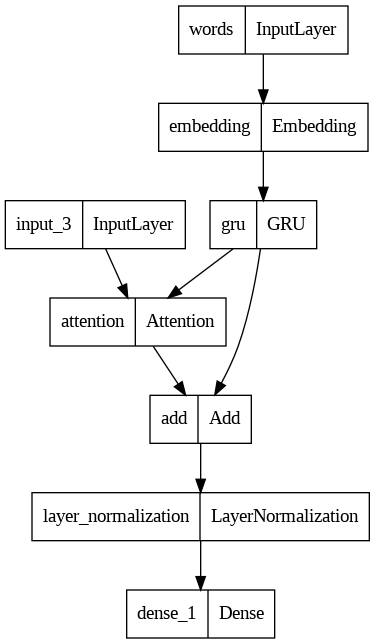

In [ ]:
decoder = tf.keras.Model(
    inputs=[word_input, encoder_output], outputs=decoder_output
)
tf.keras.utils.plot_model(decoder)

In [ ]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 words (InputLayer)          [(None, 64)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 64, 512)              1024000   ['words[0][0]']               
                                                          0                                       
                                                                                                  
 gru (GRU)                   [(None, 64, 512),            1575936   ['embedding[1][0]']           
                              (None, 512)]                                                        
                                                                                            

### Training Model

Now, combine the encoder and the decoder into an image model for training.

* Input: `image_input` and `word_input`
* Output: `decoder_output`

In [ ]:
image_caption_train_model = tf.keras.Model(
    inputs=[image_input, word_input], outputs=decoder_output
)

### Loss Function
The loss function is a simple `SparseCategoricalCrossentropy`, but I need to remove the caption paddings (`0`) when calculating it. So, extract the length of the sentence (non-0 part), and compute the average of the loss only over the valid sentence part.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    loss_ = loss_object(real, pred)

    # returns 1 to word index and 0 to padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=tf.int32)
    sentence_len = tf.reduce_sum(mask)
    loss_ = loss_[:sentence_len]

    return tf.reduce_mean(loss_, 1)

In [ ]:
image_caption_train_model.compile(
    optimizer="adam",
    loss=loss_function,
)

## Training loop

Now we can train the model using the standard `model.fit` API.<br>
It takes around 15-20 minutes with NVIDIA T4 GPU to train 1 epoch. I trained the model for 3 epochs.

In [ ]:
%%time
history = image_caption_train_model.fit(batched_ds, epochs=2)

Epoch 1/2
2586/2586 [==============================] - 945s 361ms/step - loss: 0.4207
Epoch 2/2
2586/2586 [==============================] - 941s 360ms/step - loss: 0.3695
CPU times: user 25min 38s, sys: 2min 51s, total: 28min 30s
Wall time: 32min 7s


In [ ]:
image_caption_train_model.save('image_caption_train_model.keras')
# new_model = tf.keras.models.load_model('my_model.keras')

## Captioning Model

Now the layers are trained, I can use them to create a captioning model. Unlike training, predicting will take the GRU states and the predicted word from the last step.

In [ ]:
gru_state_input = Input(shape=(ATTENTION_DIM), name="gru_state_input")

# Reuse trained GRU, but update it so that it can receive states.
gru_output, gru_state = decoder_gru(embed_x, initial_state=gru_state_input)

# Reuse other layers as well
context_vector = decoder_attention([gru_output, encoder_output])
addition_output = Add()([gru_output, context_vector])
layer_norm_output = layer_norm(addition_output)

decoder_output = decoder_output_dense(layer_norm_output)

# Define prediction Model with state input and output
decoder_pred_model = tf.keras.Model(
    inputs=[word_input, gru_state_input, encoder_output],
    outputs=[decoder_output, gru_state],
)



1. Initialize the GRU states as zero vectors.
1. Preprocess an input image, pass it to the encoder, and extract image features.
1. Setup word tokens of `<start>` to start captioning.
1. In the for loop, we
    - pass word tokens (`dec_input`), GRU states (`gru_state`) and image features (`features`) to the prediction decoder and get predictions (`predictions`), and the updated GRU states.
    - select Top-K words from logits, and choose a word probabilistically so that we avoid computing softmax over VOCAB_SIZE-sized vector.
    - stop predicting when the model predicts the `<end>` token.
    - replace the input word token with the predicted word token for the next step.

In [ ]:
MINIMUM_SENTENCE_LENGTH = 5


## Probabilistic prediction using the trained model
def predict_caption(filename):
    gru_state = tf.zeros((1, ATTENTION_DIM))

    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    for i in range(MAX_CAPTION_LEN):
        predictions, gru_state = decoder_pred_model(
            [dec_input, gru_state, features]
        )

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=predictions[0][0], k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])

        if predicted_id == word_to_index("<end>"):
            return img, result

        dec_input = tf.expand_dims([predicted_id], 1)

    return img, result

## Testing

I tested 5 images:

1. People playing baseball.
2. A man surfing waves.
3. A woman carring two lambs in a farm.
4. Corndogs in a basket.
5. A sloth hugging a tree.

1. The first image is well-captioned.

baseball players on the field getting ready together in the field.
a baseball pitcher throwing a baseball while another boy watches.
a couple of men standing on a baseball field.
a group of baseball players playing baseball in a baseball field.
a baseball player hitting the ball with a batter.


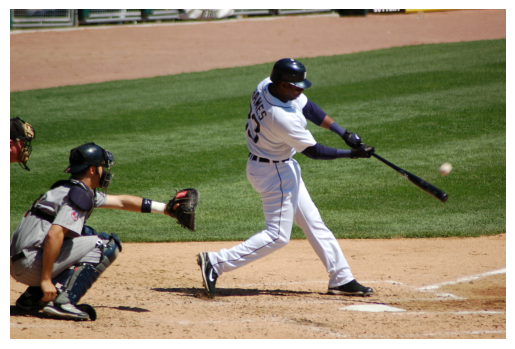

In [ ]:
filename = "baseball.jpeg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

2. The second image is well-captioned, too. The model got confused about the gender of the surfer, but it grasped the main idea of the image.

a man riding on top of a wave in the ocean.
a person that surfboard in the ocean with a surf board.
a man riding a kiteboard over a body of water.
a beautiful young woman riding a boogie board on a wave.
a surfer seemed to ride a wave on a wave.


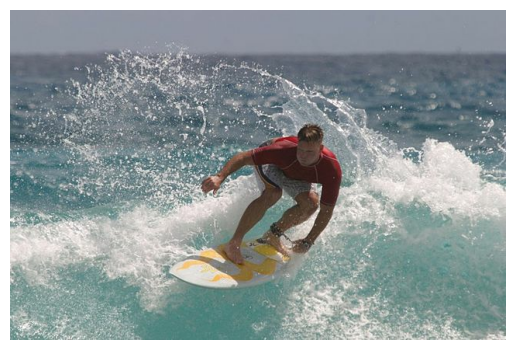

In [ ]:
filename = "surf.jpeg"
for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

3. This result is not too accurate. So far, the model seems to perform better in classifying human than anything else.

two girls are holding a sheep next to a truck.
a woman petting a teddy bear with a bear.
a woman in denim shirt opening a dog with a leash.
a woman holding a teddy bear walking down a sidewalk.
a woman standing next to a small goat.


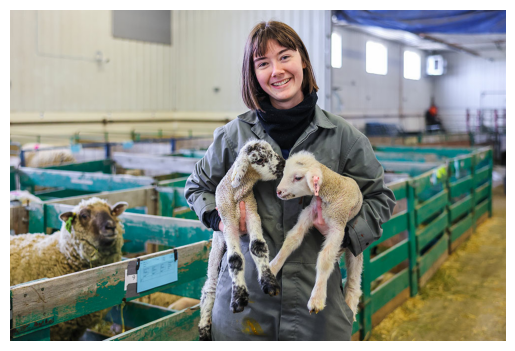

In [ ]:
filename = "lambs.jpg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

4. The model can tell the image contains food, but it couldn't reliably distinguish the type of food. When I only trained the model for 1 epoch, it thought the corndogs were submarine. Since 3 epochs allows it to tell that this is food, I believe more training will increase the accuracy.

a couple of plates of food on a table.
a plate of food with some fruit on them.
a plate topped with waffles sliced up half banana next to berries.
a couple of plates topped hot dogs with a cut in half lemon.
a white table topped with plates and dishes full of food.


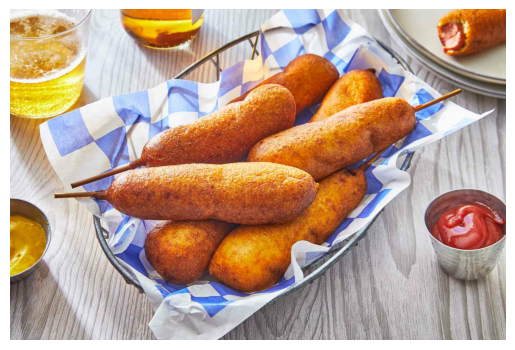

In [ ]:
filename = "corndogs.jpg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

5. I tried an image smaller than the input size (299, 299), and the sloth in the image is well-camouflaged with the white tree. The model was very confused, and couldn't produce any useful captions.

a very tall basket that is in the grass.
a yellow and green train that is sitting in the middle of a flower.
a couple of men on top of a green field.
a couple of yellow frosted chairs and a yellow banana.
a couple of men standing on top of a table holding a yellow frisbee.


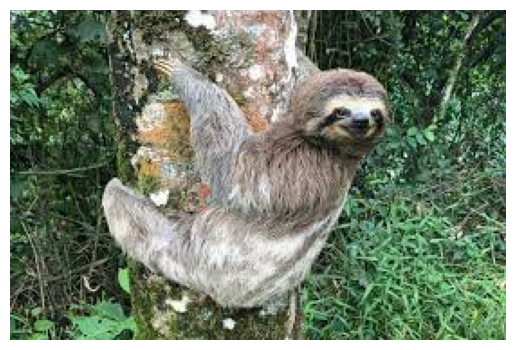

In [ ]:
filename = "sloth.jpg"

for i in range(5):
    image, caption = predict_caption(filename)
    print(" ".join(caption[:-1]) + ".")

img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

Despite the short training time (~ 1 hour), the model can identify and highlight some major components in the images. I noticed that model worked better with images with fewer information (patterns, objects, colors, etc.). There are some grammatical errors in the captions, but the meaning is still understandable.